In [1]:
# Install required libraries
!pip install pandas scipy scikit-learn seaborn matplotlib
!pip install tabulate


# Import required libraries
import pandas as pd
from IPython.display import display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Upload the .arff file manually
from google.colab import files
uploaded = files.upload()

# Load the .arff file into a DataFrame
data, meta = arff.loadarff('Rice_Cammeo_Osmancik.arff')
df = pd.DataFrame(data)

# Decode byte data in columns
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].str.decode('utf-8')

# Check first few rows of the dataset to confirm successful loading
df.head()


Saving Rice_Cammeo_Osmancik.arff to Rice_Cammeo_Osmancik.arff


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,Cammeo
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,Cammeo
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,Cammeo
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,Cammeo
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,Cammeo


In [3]:
# Display descriptive statistics as a well-formatted table
print("Descriptive Statistics:")
display(df.describe().style.format("{:.2f}").set_caption("Descriptive Statistics Table").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '16px'), ('text-align', 'center')]}]
))

Descriptive Statistics:


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.00,3810.00,3810.00,3810.00,3810.00,3810.00,3810.00
mean,12667.73,454.24,188.78,86.31,0.89,12952.50,0.66
std,1732.37,35.60,17.45,5.73,0.02,1776.97,0.08
min,7551.00,359.10,145.26,59.53,0.78,7723.00,0.50
25%,11370.50,426.14,174.35,82.73,0.87,11626.25,0.60
50%,12421.50,448.85,185.81,86.43,0.89,12706.50,0.65
75%,13950.00,483.68,203.55,90.14,0.90,14284.00,0.73
max,18913.00,548.45,239.01,107.54,0.95,19099.00,0.86


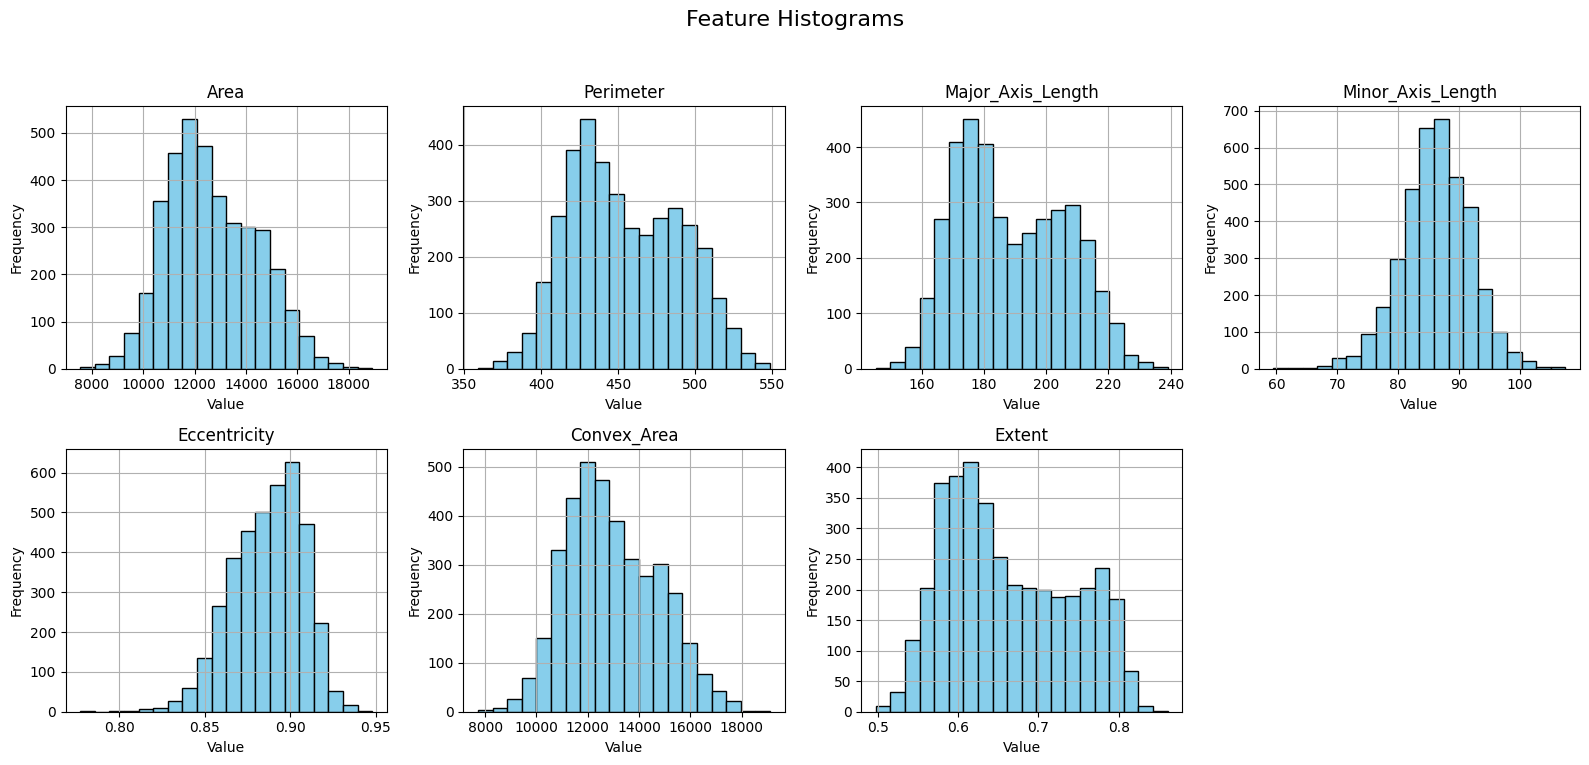

In [4]:
# Set up a 2x4 grid for subplots to display each feature's histogram
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Adjust size for smaller individual plots
fig.suptitle("Feature Histograms", fontsize=16)

# List of features in the dataset
features = df.columns[:-1]  # Assuming the last column is the target 'Class'

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    row, col = divmod(i, 4)
    df[feature].hist(bins=20, ax=axes[row, col], color='skyblue', edgecolor='black')
    axes[row, col].set_title(feature)
    axes[row, col].set_xlabel("Value")
    axes[row, col].set_ylabel("Frequency")

# Remove any empty subplot if number of features < 8
for j in range(i+1, 8):
    row, col = divmod(j, 4)
    fig.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title and reduce spacing
plt.show()

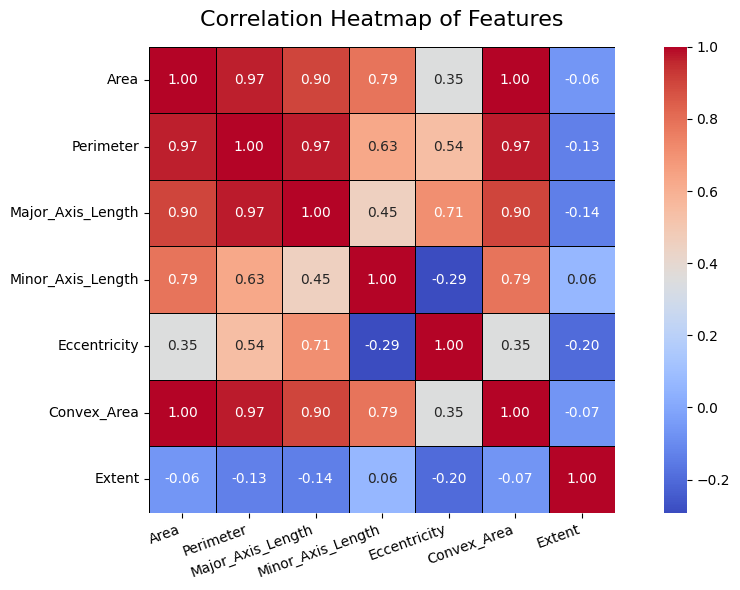

In [5]:
# Select only numeric columns for the correlation calculation
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Generate a heatmap with improved aesthetics
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
            linewidths=0.5, linecolor='black', annot_kws={"size": 10})

# Title and other aesthetics
plt.title("Correlation Heatmap of Features", fontsize=16, pad=15)
plt.xticks(rotation=20, fontsize=10, ha='right')
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

plt.show()


Class Balance:
Class
Osmancik    2180
Cammeo      1630


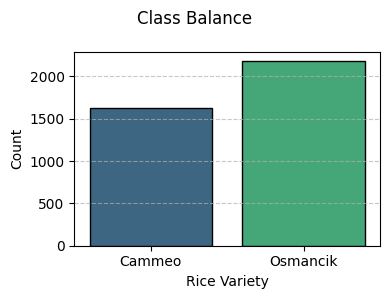

In [6]:
# Check class balance with clean output
print("Class Balance:")
print(df['Class'].value_counts().to_string(index=True))

# Visualize class balance with a smaller, visually appealing plot
plt.figure(figsize=(4, 3))  # Adjust figure size
sns.countplot(data=df, x='Class', palette="viridis", edgecolor='black')  # Edge color for better visual distinction

plt.suptitle("Class Balance")
plt.xlabel("Rice Variety", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a light grid on y-axis for readability

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [7]:
# Check for missing values in the DataFrame
missing_values = df.isnull().sum().to_dict()  # Convert to dictionary to remove dtype

# Display missing values information
print("Missing Values Per Feature:")
for feature, count in missing_values.items():
    print(f"{feature}: {count}")

# Check and display if there are any missing values
total_missing = sum(missing_values.values())
if total_missing == 0:
    print("\nNo missing values detected in the dataset.")
else:
    print(f"\nTotal missing values in dataset: {total_missing}")
    print("Proceeding to drop rows with missing values (if applicable).")

    # Drop rows with missing values
    df = df.dropna()

    # Confirm missing values removal
    print("\nUpdated Missing Values Count After Dropping Rows:")
    updated_missing_values = df.isnull().sum().to_dict()
    for feature, count in updated_missing_values.items():
        print(f"{feature}: {count}")


Missing Values Per Feature:
Area: 0
Perimeter: 0
Major_Axis_Length: 0
Minor_Axis_Length: 0
Eccentricity: 0
Convex_Area: 0
Extent: 0
Class: 0

No missing values detected in the dataset.


In [8]:
def cap_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

# Apply outlier capping
numeric_features = df.select_dtypes(include=[np.number]).columns
df = cap_outliers(df, numeric_features)

# Confirm changes by rechecking the descriptive stats
df.describe().style.set_caption("Capped Outliers")

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,12667.267454,454.239180,188.776222,86.326474,0.886932,12952.146949,0.661934
std,1730.887966,35.597081,17.448679,5.615361,0.020605,1775.858126,0.077239
min,7551.000000,359.100006,145.264465,71.613723,0.827122,7723.000000,0.497413
25%,11370.500000,426.144753,174.353855,82.731695,0.872402,11626.250000,0.598862
50%,12421.500000,448.852493,185.810059,86.434647,0.889050,12706.500000,0.645361
75%,13950.000000,483.683746,203.550438,90.143677,0.902588,14284.000000,0.726562
max,17819.250000,548.445984,239.010498,101.261649,0.947868,18270.625000,0.861050


In [9]:
# Encode target variable
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])

# Display encoded target variable
print("Encoded Target Variable:")
print(df['Class'].unique())  # Shows the unique encoded values
print("Classes:", encoder.classes_)  # Shows the mapping of original class names to encoded values

# Scale numeric features
numeric_features = df.select_dtypes(include=[np.number]).columns  # Identify numeric features
scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Display scaled data as a styled table
df.head().style.set_caption("Scaled Data (First 5 Rows)").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '16px'), ('text-align', 'center')]}]
)

Encoded Target Variable:
[0 1]
Classes: ['Cammeo' 'Osmancik']


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,0.747937,0.879232,0.901216,0.454671,0.842763,0.748415,0.207577,0.000000
1,0.691939,0.714095,0.648087,0.678538,0.565512,0.696745,0.324564,0.000000
2,0.689796,0.750066,0.734349,0.544880,0.703927,0.685557,0.538576,0.000000
3,0.547805,0.524136,0.512800,0.534090,0.536160,0.535192,0.393954,0.000000
4,0.695055,0.781992,0.709138,0.596964,0.658980,0.714758,0.408680,0.000000



KNN Performance:
+-----------+----------+
| Metric    |    Score |
+===========+==========+
| Accuracy  | 0.905512 |
+-----------+----------+
| Precision | 0.901734 |
+-----------+----------+
| Recall    | 0.891429 |
+-----------+----------+
| F1 Score  | 0.896552 |
+-----------+----------+

Decision Tree Performance:
+-----------+----------+
| Metric    |    Score |
+===========+==========+
| Accuracy  | 0.877953 |
+-----------+----------+
| Precision | 0.879056 |
+-----------+----------+
| Recall    | 0.851429 |
+-----------+----------+
| F1 Score  | 0.865022 |
+-----------+----------+


<Figure size 1000x500 with 0 Axes>

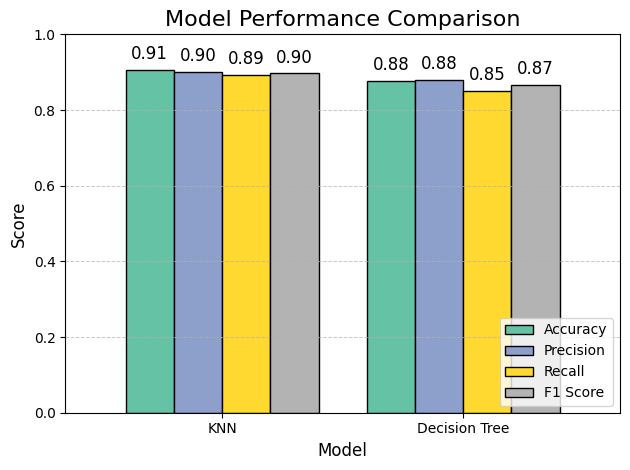

In [14]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.io import arff

# Load the .arff file
data, meta = arff.loadarff('/content/Rice_Cammeo_Osmancik.arff')
df = pd.DataFrame(data)

# Convert binary class values to string if needed
df['Class'] = df['Class'].str.decode('utf-8')

# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for both training and testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

######################################
# K-Nearest Neighbors Classifier
######################################

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)
knn_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "Precision": precision_score(y_test, y_pred_knn, pos_label="Cammeo"),
    "Recall": recall_score(y_test, y_pred_knn, pos_label="Cammeo"),
    "F1 Score": f1_score(y_test, y_pred_knn, pos_label="Cammeo")
}
print("\nKNN Performance:")
print(tabulate(knn_metrics.items(), headers=["Metric", "Score"], tablefmt="grid"))

######################################
# Decision Tree Classifier
######################################

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
dt_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt, pos_label="Cammeo"),
    "Recall": recall_score(y_test, y_pred_dt, pos_label="Cammeo"),
    "F1 Score": f1_score(y_test, y_pred_dt, pos_label="Cammeo")
}
print("\nDecision Tree Performance:")
print(tabulate(dt_metrics.items(), headers=["Metric", "Score"], tablefmt="grid"))

######################################
# Combine Metrics for KNN and Decision Tree
######################################

metrics_df = pd.DataFrame({
    "KNN": knn_metrics,
    "Decision Tree": dt_metrics
}).T

# Plot metrics for both models
plt.figure(figsize=(10, 5))
ax = metrics_df.plot(kind="bar", rot=0, colormap="Set2", edgecolor="black", width=0.8)

# Adding annotations to show values on bars
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v.get_height():.2f}' for v in container], fontsize=12, padding=5)

plt.title("Model Performance Comparison", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()



Confusion Matrix - K-Nearest Neighbors:
[[312  38]
 [ 34 378]]


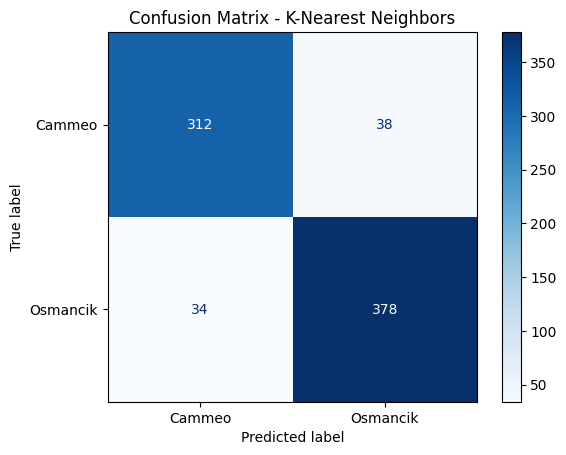


Confusion Matrix - Decision Tree:
[[298  52]
 [ 41 371]]


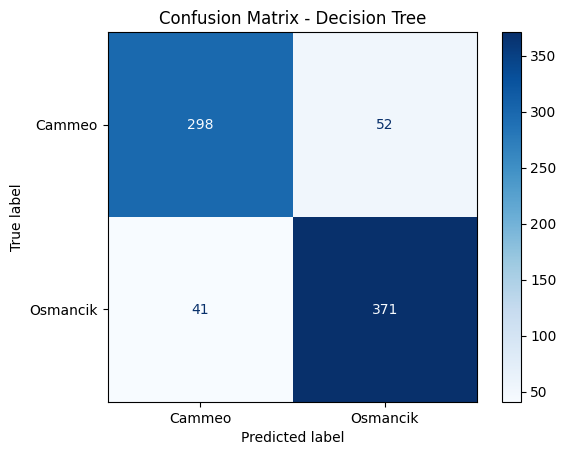

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix for K-Nearest Neighbors
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn, labels=["Cammeo", "Osmancik"])
print("\nConfusion Matrix - K-Nearest Neighbors:")
print(conf_matrix_knn)

# Visualize the confusion matrix for K-Nearest Neighbors
disp_knn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn, display_labels=["Cammeo", "Osmancik"])
disp_knn.plot(cmap="Blues")
plt.title("Confusion Matrix - K-Nearest Neighbors")
plt.show()

# Confusion matrix for Decision Tree
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt, labels=["Cammeo", "Osmancik"])
print("\nConfusion Matrix - Decision Tree:")
print(conf_matrix_dt)

# Visualize the confusion matrix for Decision Tree
disp_dt = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dt, display_labels=["Cammeo", "Osmancik"])
disp_dt.plot(cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.show()
